# Telecomunicaciones: identificar operadores ineficaces.

# Definición de objetivo.

Analizar los registros de llamadas del servicio de telefonía virtual CallMeMaybe para detectar patrones de desempeño entre operadores, identificar a aquellos considerados ineficaces según métricas clave (llamadas perdidas, tiempos de espera y volumen de llamadas salientes) y validar estadísticamente las diferencias observadas. 

El fin es generar información confiable y accionable que permita a los supervisores mejorar la gestión de sus equipos y optimizar la calidad del servicio.

# Audiencia

Este informe está dirigido a **supervisores y gerencia**.  
El objetivo es identificar operadores ineficaces mediante métricas objetivas, visualizaciones ejecutivas y conclusiones accionables.

# Especificación de detalles.

Transformar datos brutos de llamadas en información clara y verificable que permita a los supervisores identificar a los operadores menos eficaces, respaldando las conclusiones con análisis exploratorio y pruebas estadísticas.

# Hipótesis propuesta.


**Llamadas entrantes perdidas**

- H₀ (nula): No hay diferencia significativa en la proporción de llamadas perdidas entre operadores ineficaces y eficaces.

- H₁ (alternativa): Los operadores ineficaces tienen una proporción significativamente mayor de llamadas perdidas que los eficaces.


**Evaluación estadística:**

- Se aplicará una prueba de proporciones (Chi-cuadrado o z-test) para comparar las tasas de llamadas perdidas.

**Magnitud del efecto (complemento a la significancia):**

- Se calculará la diferencia absoluta de proporciones:

Δ𝑝 =𝑝 ineficaces − 𝑝 eficaces

- Se reportará también la razón de proporciones (riesgo relativo):

  RR= 𝑝 ineficaces / 𝑝 eficaces

- Se acompañará con un intervalo de confianza (95%) para Δp y RR, lo que permitirá evaluar la magnitud y precisión de la diferencia observada.

# Etapa 1.- Revisión inicial de datos (preprocesamiento).

En esta etapa lo primero es proceder a cargar ambos datasets:

- **telecom_clients_us (Clientes)**
- **telecom_dataset_us (Llamadas)**

A continuación, revisamos los tipos de datos contenidos en los datasets.

Convertiremos los datos que así convenga hacerlo, validaremos si existen valores duplicados, valores ausentes y valores atípicos. Esto como parte de la limpieza en ambos datasets.

In [1]:
# 1. Carga de datos

import pandas as pd

# Cargar datasets

df_clients = pd.read_csv("telecom_clients_us.csv")
df_calls = pd.read_csv("telecom_dataset_us.csv")

# Información general de clientes
print("=== Dataset CLIENTES ===")
print(df_clients.info())

# Información general de llamadas
print("\n=== Dataset LLAMADAS ===")
print(df_calls.info())


=== Dataset CLIENTES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None

=== Dataset LLAMADAS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        

In [2]:
# 2. Conversión de tipos

# Fechas
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'], errors='coerce')
df_calls['date'] = pd.to_datetime(df_calls['date'], errors='coerce')

In [3]:
print("=== Dataset CLIENTES ===")
print(df_clients.info())

# Información general de llamadas
print("\n=== Dataset LLAMADAS ===")
print(df_calls.info())


=== Dataset CLIENTES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB
None

=== Dataset LLAMADAS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   oper

In [4]:
#3 Visualizar valores ausentes y duplicados

print("=== VALORES AUSENTES ===")
print("\nClientes:")
print(df_clients.isnull().sum())

print("\nLlamadas:")
print(df_calls.isnull().sum())
# -------------------------------
# Duplicados
# -------------------------------
print("\n=== DUPLICADOS ===")
print("Duplicados en clientes:", df_clients.duplicated().sum())
print("Duplicados en llamadas:", df_calls.duplicated().sum())

=== VALORES AUSENTES ===

Clientes:
user_id        0
tariff_plan    0
date_start     0
dtype: int64

Llamadas:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

=== DUPLICADOS ===
Duplicados en clientes: 0
Duplicados en llamadas: 4900


**📂Dataset Clientes**

Duplicados: 0 

Nulos: ninguno.

Tipos de datos:

- user_id: entero

- tariff_plan: texto

- date_start: fecha (datetime)

## **Dataset "Clientes" limpio y listo para trabajar.**
<br>

**☎️Dataset Llamadas**

Duplicados: 4900 registros duplicados → conviene eliminarlos.

Nulos:

- internal: 117

- operator_id: 8172 (importante, habrá que decidir cómo manejarlos: ¿descartar esas filas? ¿o analizarlos como “no asignados”?)

Tipos de datos:

- date convertido a datetime (zona horaria)

- operator_id está en float por los nulos, idealmente debería ser entero.

## **Preprocesamiento "Dataset Llamadas"**

- Valores duplicados
- Valores ausentes
- Outliers

### Valores duplicados.
**En el caso del dataset de llamadas tomamos la decisión de eliminar los registros duplicados.
En este caso, sí conviene eliminarlos, porque no agregan valor y pueden sesgar conteos de llamadas, promedios de duración, etc.**

In [5]:
#Eliminación de registros duplicados en "telecom_dataset_us"

print("Duplicados antes:", df_calls.duplicated().sum())
df_calls = df_calls.drop_duplicates()
print("Duplicados después:", df_calls.duplicated().sum())

Duplicados antes: 4900
Duplicados después: 0


### Valores ausentes.

**a) operator_id (faltantes)**

Hay miles de llamadas sin operador asignado.

Esto puede pasar por registros de prueba, errores del sistema o llamadas que no llegaron a conectarse.

Opciones:

1) Si el análisis es “por operador” → filtramos y trabajamos solo con registros que tengan operator_id.

2) Si el análisis es general (todas las llamadas) → dejamos los NaN y los consideramos como categoría “sin asignar” al contar.

**Optamos por la segunda opción.
Al calcular métricas de eficacia de operadores, los ignoraremos.**

**b) internal (faltantes)**

- Solo son unos cientos.

- Es un campo categórico (True/False).

- Aquí sí conviene rellenar con "unknown" para no perder registros.

In [6]:
# a) operator_id: mantener como NaN pero usando tipo entero tolerante a nulos
df_calls['operator_id'] = df_calls['operator_id'].astype("Int64")

# b) internal: reemplazar por 'unknown'
df_calls['internal'] = df_calls['internal'].fillna("unknown")



### Outliers (casi como “ausentes extremos”).

Encontramos duraciones imposibles (llamadas de 10h, 20h, hasta 40h 🤯).

No son “NaN”, pero distorsionan los promedios.<br>
**Mejor filtrarlos con un límite razonable (ej. 12 horas = 43,200 segundos).**

In [7]:
max_duration = 43200
df_calls = df_calls[
    (df_calls['call_duration'] <= max_duration) &
    (df_calls['total_call_duration'] <= max_duration)
]

**En resumen:**

- Duplicados → eliminar.

- operator_id nulo → mantener como NaN, pero excluir al analizar operadores.

- internal nulo → rellenar con "unknown".

- Duraciones irreales → filtrar >12h.

### Validación final de preprocesamiento para ambos datasets.

In [8]:
print("\nShape final CLIENTES:", df_clients.shape)
print("Shape final LLAMADAS:", df_calls.shape)

print("\nValores nulos CLIENTES:\n", df_clients.isnull().sum())
print("\nValores nulos LLAMADAS:\n", df_calls.isnull().sum())

print("\nTipos de datos CLIENTES:\n", df_clients.dtypes)
print("\nTipos de datos LLAMADAS:\n", df_calls.dtypes)

print("\nVista previa LLAMADAS:\n", df_calls.head())


Shape final CLIENTES: (732, 3)
Shape final LLAMADAS: (48892, 9)

Valores nulos CLIENTES:
 user_id        0
tariff_plan    0
date_start     0
dtype: int64

Valores nulos LLAMADAS:
 user_id                   0
date                      0
direction                 0
internal                  0
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Tipos de datos CLIENTES:
 user_id                 int64
tariff_plan            object
date_start     datetime64[ns]
dtype: object

Tipos de datos LLAMADAS:
 user_id                                    int64
date                   datetime64[ns, UTC+03:00]
direction                                 object
internal                                  object
operator_id                                Int64
is_missed_call                              bool
calls_count                                int64
call_duration                              int64
tota

### Resumen de acciones para el preprocesamiento de ambos datasets.

- Carga de los datasets.

- Conversión fechas a datetime64.

- Eliminación de duplicados.

- Manejo de valores nulos (internal → "unknown", operator_id → NaN con soporte).

- Filtrado de outliers de duración (> 12h).

- Muestra de validación final (shape, nulos, tipos de datos y preview).

## **Checkpoint 1.- Limpieza validada.**

### **Ahora daremos paso al Análisis Exploratorio de Datos.**

# Etapa 2.- Análisis Exploratorio de Datos.

En esta etapa vamos a dejar de ver solo calidad de datos y empezamos a explorar patrones y métricas clave.

**Objetivos**

1. Calcular métricas básicas por operador:

- Número total de llamadas entrantes recibidas.

- Número y proporción de llamadas entrantes perdidas.

- Tiempo promedio y mediano de espera en llamadas entrantes.

- Número total de llamadas salientes realizadas.

2. Explorar distribuciones y tendencias:

- Histograma de duración de llamadas.

- Gráfico circular internas vs externas.

- Evolución de llamadas por día.

3. Detectar variaciones entre operadores:

- Boxplots para comparar distribuciones de tiempos de espera y llamadas perdidas.

- Ranking de operadores por métricas clave.

**Propuesta de métricas a construir**

- Tasa de llamadas perdidas:

**Missed Rate=Llamadas perdidas/Llamadas entrantes totales**

- Tiempo de espera promedio:

**Avg Wait Time=mean(total_call_duration−call_duration)**

- Volumen de llamadas salientes:

**Outgoing Calls=∑calls_count (direction=out)**

### 1. Calcular métricas básicas por operador:

In [9]:
# ============================
# Métricas básicas por operador
# ============================

import numpy as np

# --- Filtrar llamadas entrantes ---
incoming = df_calls[df_calls['direction'] == 'in'].copy()

# Agrupar por operador
incoming_metrics = incoming.groupby('operator_id').agg(
    total_incoming=('calls_count', 'sum'),
    missed_incoming=('is_missed_call', lambda x: (x * 1).sum()),
    total_call_duration=('total_call_duration', 'sum'),
    talk_duration=('call_duration', 'sum'),
    median_wait_time=('total_call_duration', 
                      lambda x: np.median(x - incoming.loc[x.index, 'call_duration']))
).reset_index()

# Proporción de llamadas perdidas
incoming_metrics['missed_rate'] = (
    incoming_metrics['missed_incoming'] / incoming_metrics['total_incoming']
).round(3)

# Tiempo de espera total y promedio
incoming_metrics['wait_time_total'] = (
    incoming_metrics['total_call_duration'] - incoming_metrics['talk_duration']
)

incoming_metrics['avg_wait_time'] = (
    incoming_metrics['wait_time_total'] / incoming_metrics['total_incoming']
).round(2)

# --- Filtrar llamadas salientes ---
outgoing = df_calls[df_calls['direction'] == 'out'].copy()

outgoing_metrics = outgoing.groupby('operator_id').agg(
    total_outgoing=('calls_count', 'sum')
).reset_index()

# --- Combinar métricas ---
metrics_basic = pd.merge(
    incoming_metrics[['operator_id', 'total_incoming', 'missed_incoming',
                      'missed_rate', 'avg_wait_time', 'median_wait_time']],
    outgoing_metrics,
    on='operator_id',
    how='outer'
).fillna(0)

# Mostrar primeras filas
metrics_basic.head(10)

,operator_id,total_incoming,missed_incoming,missed_rate,avg_wait_time,median_wait_time,total_outgoing
0,879896,58.0,0.0,0.0,9.90,16.0,872.0
1,879898,104.0,0.0,0.0,16.15,14.0,7209.0
2,880020,7.0,0.0,0.0,7.71,7.0,38.0
3,880022,8.0,0.0,0.0,14.00,16.0,189.0
4,880026,24.0,0.0,0.0,5.96,6.5,2208.0
5,880028,63.0,0.0,0.0,5.44,7.0,2497.0
6,880240,0.0,0.0,0.0,0.00,0.0,47.0
7,881278,0.0,0.0,0.0,0.00,0.0,20.0
8,882476,3.0,0.0,0.0,31.67,20.0,0.0
9,882478,3.0,0.0,0.0,25.33,38.0,1.0


### Resumen estadístico de las métricas básicas por operador

In [10]:
metrics_summary = metrics_basic.describe().T  # Transpuesta para mayor legibilidad
metrics_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

,mean,std,min,25%,50%,75%,max
operator_id,925517.543956,22854.532209,879896.0,906393.5,925105.0,944211.5,973286.0
total_incoming,85.899267,301.669602,0.0,0.0,5.0,34.25,4766.0
missed_incoming,0.627289,2.042021,0.0,0.0,0.0,0.0,28.0
missed_rate,0.009865,0.046286,0.0,0.0,0.0,0.0,1.0
avg_wait_time,12.077518,12.950098,0.0,0.0,10.075,17.5625,115.5
median_wait_time,34.367216,76.441753,0.0,0.0,15.5,36.0,953.0
total_outgoing,492.201465,1718.982319,0.0,2.0,33.0,355.25,30142.0


A partir de este resumen estadístico presentamos los siguientes puntos clave:

### Llamadas entrantes

- **Promedio (total_incoming):** ~86 llamadas entrantes por operador.

- **Mediana: solo 5 llamadas** → distribución muy sesgada (pocos operadores concentran muchísimas llamadas).

- **Máximo:** hasta 4,766 llamadas en un operador.

**Hay una minoría de operadores que reciben una cantidad enorme de llamadas.**

### Llamadas perdidas

- **Promedio (missed_incoming):** <1 llamada perdida por operador.

- **Mediana** = 0 → la mayoría de operadores no pierden llamadas.

- **Máximo**: 28 perdidas en un operador.

**La pérdida de llamadas es un problema de unos pocos operadores, no generalizado.**

### Tasa de llamadas perdidas

- **Promedio (missed_rate):** ~0.9%.

- **Mediana =** 0 → la mayoría no pierde nada.

- **Máximo =** 1.0 → algunos operadores pierden el 100% de sus llamadas.

**Aquí hay un indicador fuerte para clasificar ineficacia.**

### Tiempo de espera promedio

- **Promedio (avg_wait_time):** ~12 segundos.

- **Mediana:** ~10 segundos.

- **Máximo:** ~115 segundos → hay operadores que hacen esperar casi 2 minutos.

**La mayoría maneja tiempos razonables, pero hay outliers graves.**

### Tiempo de espera mediano

- **Promedio:** ~34 segundos.

- **Mediana:** ~15.5 segundos.

- **Máximo:** ~953 segundos (más de 15 minutos).

El indicador confirma que aunque la mayoría de operadores tiene medianas bajas, existen casos extremos de **esperas críticas.**

### Llamadas salientes:

- **Promedio (total_outgoing):** ~492 llamadas por operador.

- **Mediana =** 33 → otra vez, distribución sesgada (pocos hacen muchísimas llamadas).

- **Máximo =** 30,142 llamadas → operadores hiperactivos.

**Este será clave para detectar a quienes deberían marcar y no lo hacen.**

### Resumen punto 1 (Calcular métricas básicas por operador), Etapa 2:

- La mayoría de operadores funcionan bien, pero hay outliers claros en llamadas perdidas, espera y volumen de salientes.

- Estos outliers son justamente los candidatos a “operadores ineficaces”.

### 2. Explorar distribuciones y tendencias.

En este punto de la etapa de EDA lo que haremos es ir más allá del simple resumen numérico: visualizaremos cómo se distribuyen los datos y si hay patrones en el tiempo o por operador.

### 2.1.- Distribución de duración de llamadas (todas)

Esto muestra si la mayoría de llamadas son muy cortas, largas o si hay colas largas (outliers).

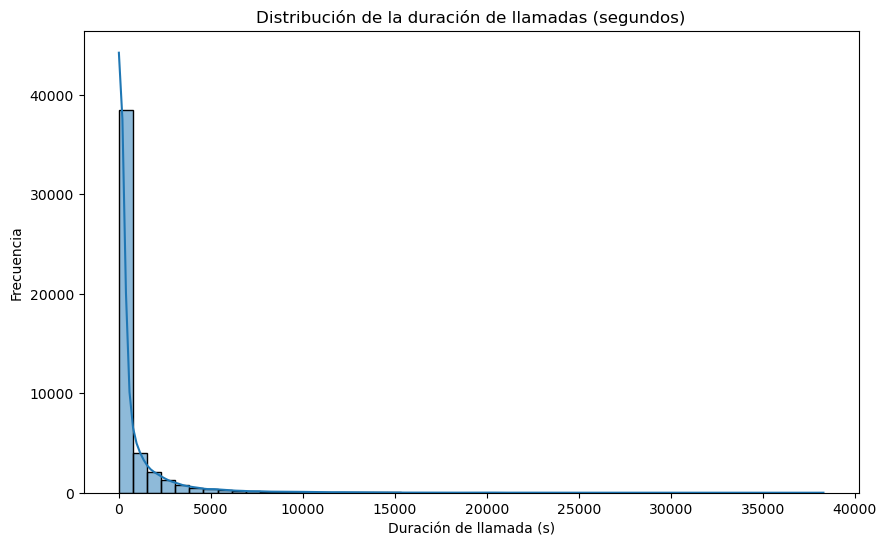

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df_calls['call_duration'], bins=50, kde=True)
plt.title("Distribución de la duración de llamadas (segundos)")
plt.xlabel("Duración de llamada (s)")
plt.ylabel("Frecuencia")
plt.show()

**Interpretación**

- La mayoría de llamadas duran poco (casi todas concentradas en el rango 0–1000 segundos).

- Hay una larga cola de outliers que llega hasta casi 40,000 segundos (~11 horas).

- Eso sugiere que probablemente haya errores en el registro (ej. llamadas colgadas que quedaron abiertas) o casos muy excepcionales que conviene revisar.

**Recomendación**

Para entender mejor los patrones sin que los outliers distorsionen la vista, recortaremos el histograma (ej. enfocarnos en llamadas de menos de 1 hora, o incluso menos de 30 minutos).

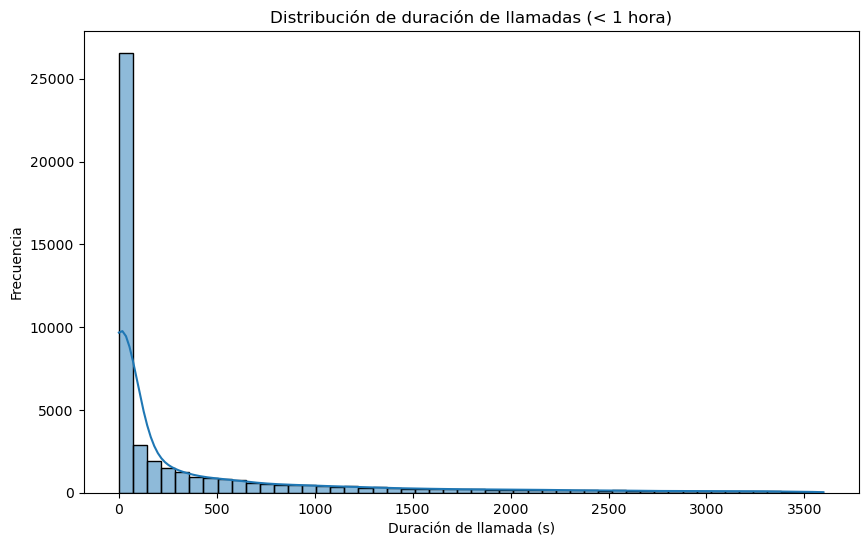

In [12]:
# Filtrar llamadas de menos de 3600s (1 hora)
plt.figure(figsize=(10,6))
sns.histplot(df_calls[df_calls['call_duration'] < 3600]['call_duration'], bins=50, kde=True)
plt.title("Distribución de duración de llamadas (< 1 hora)")
plt.xlabel("Duración de llamada (s)")
plt.ylabel("Frecuencia")
plt.show()

### 2.2.- Distribución de llamadas internas vs externas

Este gráfico nos muestra si el tráfico está dominado por llamadas al cliente o entre operadores.

In [13]:
# Conteo de llamadas internas vs externas
conteo_internal = df_calls['internal'].value_counts()

print("Conteo de llamadas:")
print(conteo_internal)

# Si quieres etiquetas más claras:
conteo_internal_labeled = df_calls['internal'].map({0: 'Externa', 1: 'Interna'}).value_counts()
print("\nConteo con etiquetas:")
print(conteo_internal_labeled)

Conteo de llamadas:
internal
False      43129
True        5653
unknown      110
Name: count, dtype: int64

Conteo con etiquetas:
internal
Externa    43129
Interna     5653
Name: count, dtype: int64


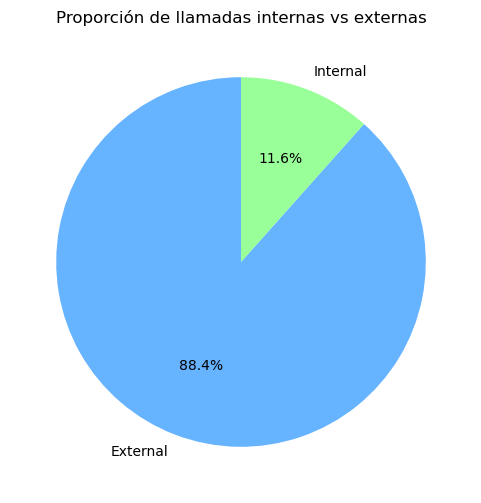

In [14]:
# Mapear valores de internal a texto claro
df_calls['internal_label'] = df_calls['internal'].map({0: 'External', 1: 'Internal'})

# Contar y graficar
plt.figure(figsize=(6,6))
df_calls['internal_label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff','#99ff99'],
    startangle=90
)
plt.title("Proporción de llamadas internas vs externas")
plt.ylabel("")
plt.show()

**Interpretación**

- **Externas =** 88.4% → La gran mayoría de las llamadas son entre clientes y operadores.

- **Internas =** 11.6% → Una fracción menor corresponde a comunicación interna entre operadores.

**Implicaciones**

- **Foco en la eficacia externa:** dado que casi 9 de cada 10 llamadas son con clientes, las métricas de pérdidas y tiempos de espera deben evaluarse sobre todo en este grupo.

- **Internas también cuentan:** aunque son menos, las internas pueden impactar la coordinación del equipo. Muchos operadores con alta proporción de internas podrían estar desviando tiempo de la atención a clientes.

- **Narrativa clara para supervisores:** el servicio está centrado en el cliente; cualquier ineficacia (perder llamadas externas, hacer esperar demasiado) tiene impacto directo en la experiencia del usuario final.

### 2.3.- Evolución de llamadas en el tiempo.

Detectaremos tendencias estacionales (ej. picos en ciertos días o caída en otros).

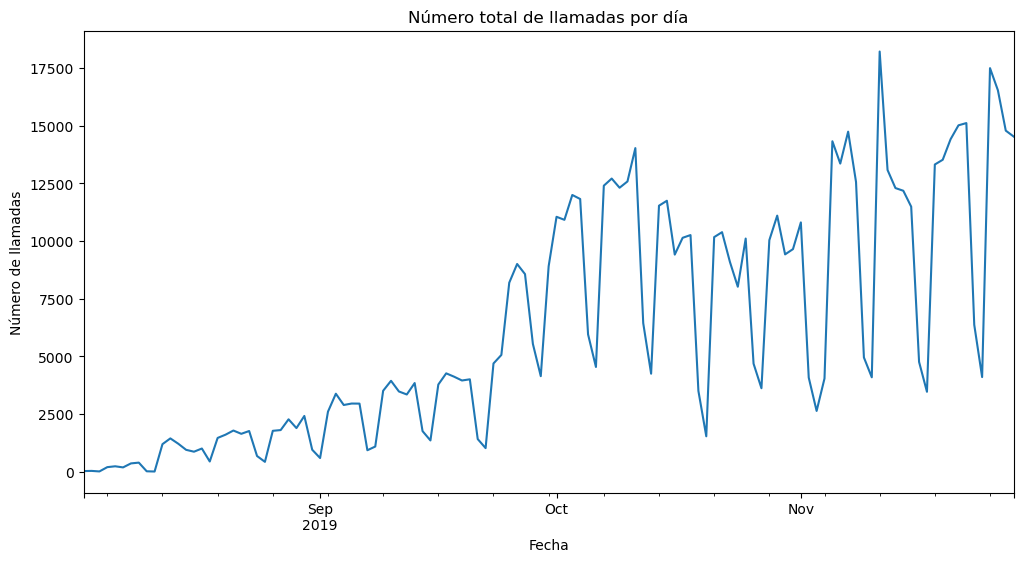

In [15]:
# Agregar llamadas por día
calls_per_day = df_calls.groupby('date')['calls_count'].sum()

plt.figure(figsize=(12,6))
calls_per_day.plot()
plt.title("Número total de llamadas por día")
plt.xlabel("Fecha")
plt.ylabel("Número de llamadas")
plt.show()

**Interpretación**

**1) Tendencia ascendente**

- Desde agosto 2019 hasta noviembre 2019 se observa un crecimiento sostenido en el volumen de llamadas diarias.

- Esto podría deberse a crecimiento en la base de clientes, campañas de marketing, o estacionalidad.

**2) Patrón semanal marcado**

- El gráfico tiene picos y valles regulares → probablemente corresponde a la diferencia entre días laborales y fines de semana.

- En fines de semana el número de llamadas cae drásticamente, mientras que entre semana hay picos de hasta 18 mil llamadas diarias.

**3) Mayor carga en octubre-noviembre**

- El nivel base de llamadas crece: en agosto las jornadas altas eran de ~3,000, en octubre ya superaban 12,000 y en noviembre alcanzan más de 18,000.

- Esto implica que la operación se intensifica con el tiempo → necesidad de más operadores o mejor distribución de carga.

**4) Variabilidad amplia**

- Los descensos bruscos refuerzan la hipótesis de fines de semana o días festivos.

- Esto también resalta la importancia de alinear staffing (número de operadores activos) con la demanda real.

### 2.4.- Distribución de tiempos de espera

Identificaremos si la mayoría de operadores tienen tiempos de espera aceptables o si hay cola larga de outliers.

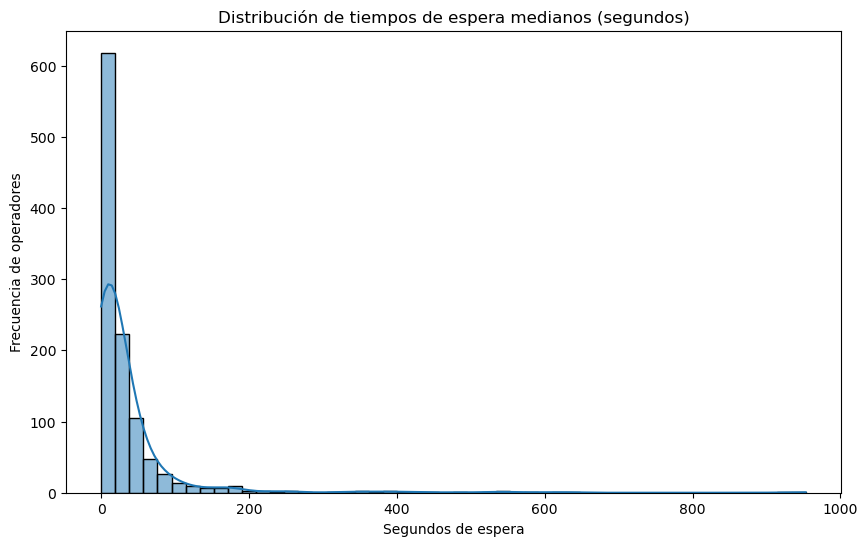

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(metrics_basic['median_wait_time'], bins=50, kde=True)
plt.title("Distribución de tiempos de espera medianos (segundos)")
plt.xlabel("Segundos de espera")
plt.ylabel("Frecuencia de operadores")
plt.show()

**Interpretación**

**1) Concentración en tiempos bajos**

- La mayoría de operadores tienen tiempos de espera medianos cercanos a 0–20 segundos.

- Esto indica que en general la atención es bastante ágil.

**2) Distribución sesgada a la derecha (long tail)**

- Aunque la mayor parte está en valores bajos, existe una cola larga de operadores con tiempos muy altos (200, 400, hasta casi 1000 segundos).

- Estos casos son atípicos y corresponden a operadores o momentos específicos donde el cliente espera demasiado.

**3) Implicación operativa**

- Para la mayoría de clientes, la experiencia es rápida → buena señal.

- Sin embargo, los outliers pueden ser críticos, porque un cliente que espera más de 5 minutos probablemente abandone la llamada o quede insatisfecho.

- Aquí se concentran los operadores “ineficaces” que justifican la hipótesis de investigación.

### 2.5.- Relación entre tasa de llamadas perdidas y total entrantes

Aquí detectamos si la ineficacia es producto de carga excesiva (muchas entrantes) o si algunos operadores fallan aún con pocas.

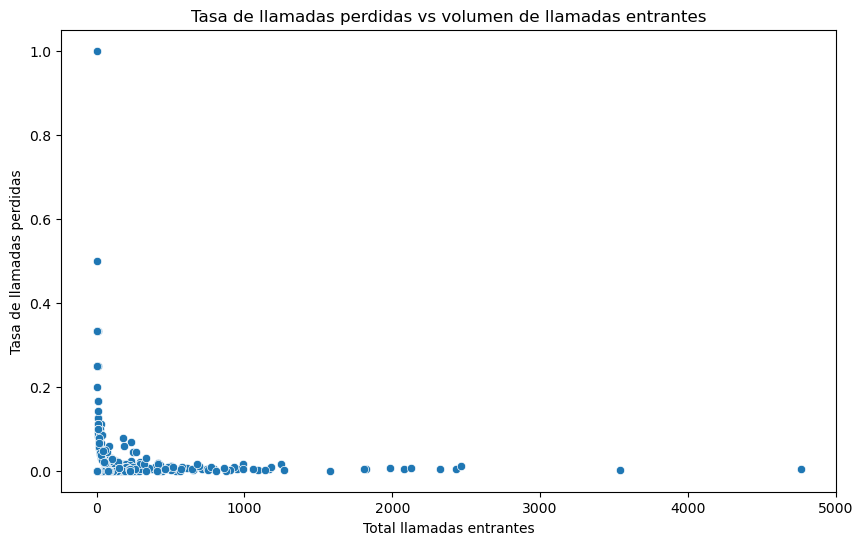

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=metrics_basic, x="total_incoming", y="missed_rate")
plt.title("Tasa de llamadas perdidas vs volumen de llamadas entrantes")
plt.xlabel("Total llamadas entrantes")
plt.ylabel("Tasa de llamadas perdidas")
plt.show()

**Interpretación**

**1) Alta dispersión en bajos volúmenes**

- Para operadores con pocas llamadas entrantes (<200), la tasa de llamadas perdidas varía muchísimo: algunos pierden todo (100%), otros no pierden nada.

- Esto refleja que con pocas observaciones, cualquier llamada perdida tiene un impacto grande en la tasa.

**2) Estabilidad con mayor volumen**

- A medida que aumenta el número de llamadas entrantes (>500), la tasa de pérdidas tiende a concentrarse cerca de 0%.

- Esto indica que los operadores con más carga suelen manejar bien la atención, lo que los hace más confiables.

### Resumen punto 2 (Explorar distribuciones y tendencias), etapa EDA

Durante el análisis exploratorio identificamos patrones clave en las llamadas:

**Duración de llamadas:**
- La gran mayoría de llamadas se concentran en duraciones cortas (unos cuantos segundos a pocos minutos), mientras que existen outliers con duraciones extremadamente largas. Esto indica que, aunque la operación es en general ágil, hay casos excepcionales que pueden estar inflando métricas.

**Internas vs externas:**
- El 88% del tráfico corresponde a llamadas externas, confirmando que el foco principal del sistema está en la interacción con clientes. Solo el 12% son llamadas internas, lo que representa comunicación entre operadores.

**Evolución en el tiempo:**
- El volumen de llamadas muestra una tendencia creciente a lo largo de los meses, con picos y caídas regulares que reflejan ciclos semanales de la operación. Esto sugiere que la demanda es estable y predecible, aunque con un incremento progresivo en la carga de trabajo.

**En conjunto, estos hallazgos permiten ver que la mayoría de los operadores trabajan en escenarios normales de llamadas cortas y externas, pero existen casos atípicos (llamadas excesivamente largas o picos de carga) que merecen un análisis más profundo en etapas posteriores.**

### 3) Comparación de métricas clave entre operadores.

- Identificar a los operadores con **mayor proporción de llamadas perdidas.**

- Detectar operadores con **tiempos de espera anómalamente altos.**

- Ver diferencias en el **volumen de llamadas salientes.**

La idea aquí ya no es ver la distribución global (como hicimos en el punto 2), sino **comparar entre operadores para encontrar a los candidatos a “ineficaces”.**

Esto va a conectar directamente con las hipótesis que se planteó al inicio (**Los operadores ineficaces tienen una proporción significativamente mayor de llamadas perdidas que los eficaces**).

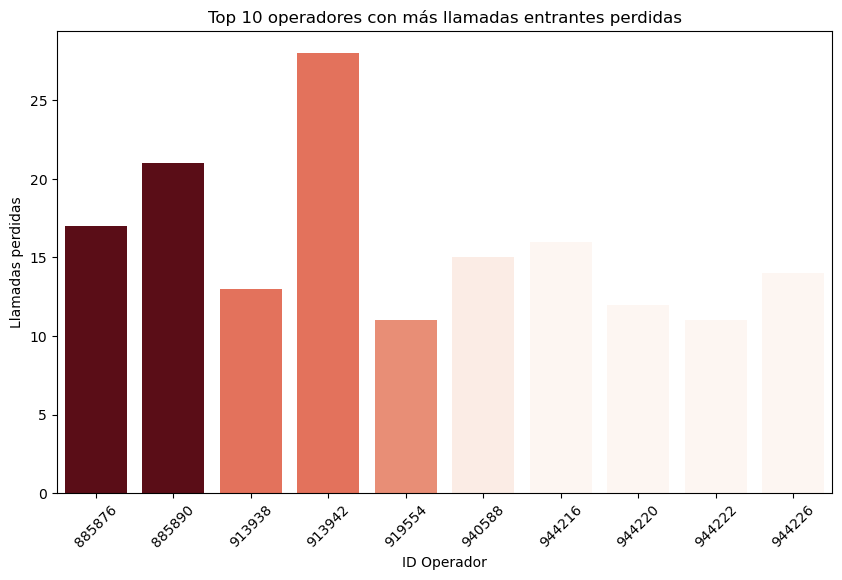

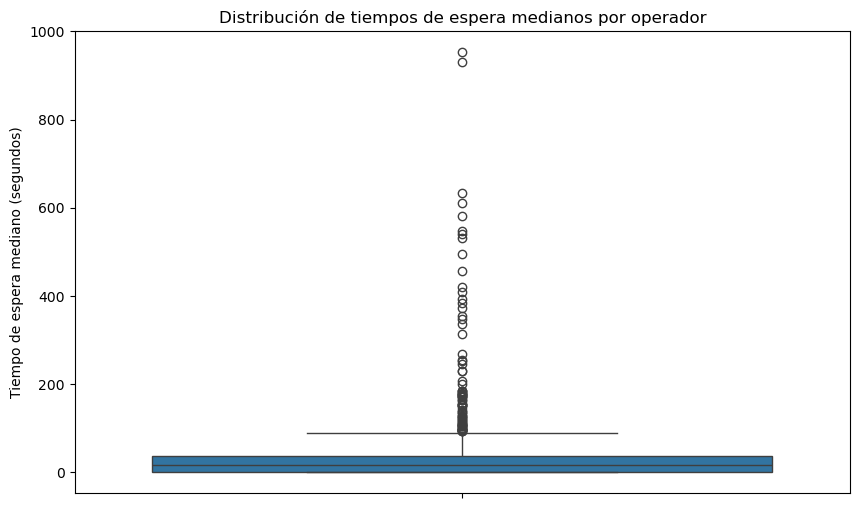

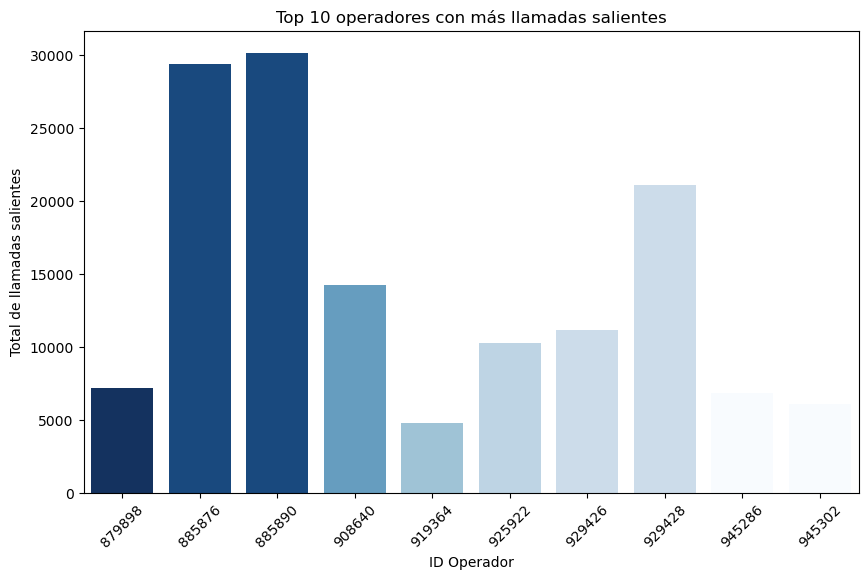

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Ranking de operadores por llamadas perdidas ---
top_missed = metrics_basic.sort_values(by="missed_incoming", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_missed, x="operator_id", y="missed_incoming", hue= "operator_id", palette="Reds_r", legend= False)
plt.title("Top 10 operadores con más llamadas entrantes perdidas")
plt.xlabel("ID Operador")
plt.ylabel("Llamadas perdidas")
plt.xticks(rotation=45)
plt.show()

# --- 2. Boxplot de tiempos de espera ---
plt.figure(figsize=(10,6))
sns.boxplot(data=metrics_basic, y="median_wait_time")
plt.title("Distribución de tiempos de espera medianos por operador")
plt.ylabel("Tiempo de espera mediano (segundos)")
plt.show()

# --- 3. Ranking de llamadas salientes ---
top_outgoing = metrics_basic.sort_values(by="total_outgoing", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_outgoing, x="operator_id", y="total_outgoing", hue= "operator_id", palette="Blues_r", legend= False)
plt.title("Top 10 operadores con más llamadas salientes")
plt.xlabel("ID Operador")
plt.ylabel("Total de llamadas salientes")
plt.xticks(rotation=45)
plt.show()

**Gráfico 1. Top 10 operadores con más llamadas entrantes perdidas**

- El operador 913942 sobresale como el peor caso, con casi 30 llamadas perdidas.

- Hay un segundo grupo (885876 y 885890) con alrededor de 20 llamadas perdidas.

- El resto tiene entre 10 y 16, lo cual también es problemático pero menos extremo.

**Este gráfico permite apuntar directamente a los outliers en eficiencia, donde la pérdida de llamadas es inaceptablemente alta.**

**Gráfico 2. Distribución de tiempos de espera medianos por operador (boxplot)**

- La mayoría de operadores se concentran en valores bajos (menores a 50 segundos).

- Sin embargo, se observan outliers extremos que superan los 600 e incluso 900 segundos (más de 10-15 minutos).

- Esto es crítico porque indica que ciertos operadores no están respondiendo de forma razonable, generando esperas excesivas.

**Aquí no basta con señalar al promedio, sino enfocarse en los operadores fuera del rango típico.**

**Gráfico 3. Top 10 operadores con más llamadas salientes**

- Algunos operadores (ej. 885876 y 885880) hacen más de 29,000 llamadas salientes, mostrando un nivel de actividad muy alto.

- La mayoría de los demás rondan entre 5,000 y 15,000.

- Esta diferencia es tan marcada que puede ser doblemente interpretada:

-- Positivo: algunos operadores están muy comprometidos y productivos.

-- Negativo: otros operadores hacen muy pocas llamadas → **potencial ineficacia.**

**En este caso, los menos activos también deben ser identificados como candidatos a ineficaces.**

### Resumen punto 3 (Comparación de métricas clave entre operadores), etapa EDA

Los tres ejes de ineficacia están bien representados:

- Llamadas perdidas → operadores críticos como 913942.

- Tiempos de espera → pocos operadores con valores extremos, que distorsionan la calidad del servicio.

- Llamadas salientes → alta concentración en unos pocos, revelando que muchos operadores están “por debajo de la expectativa”.

Esto confirma que el siguiente paso debe ser **definir criterios claros para clasificar a un operador como ineficaz.**

### Conclusiones etapa 2, Análisis Exploratorio de Datos (EDA)

- La mayoría de operadores trabajan con niveles aceptables de eficacia.

- Los problemas detectados son concentrados en una minoría: algunos con demasiadas pérdidas, otros con esperas excesivas y otros con baja productividad saliente.

- Esto justifica pasar a la siguiente etapa: **definir criterios objetivos de ineficacia** que permitan clasificar a los operadores de forma justa y transparente.

## **Checkpoint 2.- Análisis validado**

# Etapa 3.- Definición de criterios objetivos de eficacia.

Tras el análisis exploratorio (EDA), ahora corresponde establecer criterios objetivos que permitan distinguir a los operadores eficaces de los ineficaces. Estos criterios se basan en métricas clave, observaciones empíricas y buenas prácticas de supervisión en entornos de call center.

## 3.1 KPI principal

**Tasa de llamadas perdidas**

**Missed Rate=** Llamadas entrantes perdidas / Total de llamadas entrantes

- **Meta:** mantener este KPI por debajo del 15%.

- **Justificación:** La pérdida de llamadas tiene impacto directo en la satisfacción del cliente y en la percepción de calidad del servicio.

In [23]:
import pandas as pd

# --- Cálculo de KPI principal: tasa de llamadas perdidas ---
# Filtrar solo llamadas entrantes
incoming = df_calls[df_calls['direction'] == 'in'].copy()

# Agrupar por operador
kpi_lost_calls = incoming.groupby('operator_id').agg(
    total_incoming=('operator_id', 'count'),
    missed_incoming=('is_missed_call', 'sum')
).reset_index()

# Calcular tasa de llamadas perdidas
kpi_lost_calls['missed_rate'] = (
    kpi_lost_calls['missed_incoming'] / kpi_lost_calls['total_incoming']
).round(3)

# Clasificar operadores según el umbral del 15%
umbral = 0.15
kpi_lost_calls['ineficaz_missed'] = kpi_lost_calls['missed_rate'] > umbral

# Ordenar por tasa de llamadas perdidas (descendente)
kpi_lost_calls = kpi_lost_calls.sort_values(by='missed_rate', ascending=False)

# Mostrar top operadores con mayor tasa de llamadas perdidas
kpi_lost_calls.head(10)

,operator_id,total_incoming,missed_incoming,missed_rate,ineficaz_missed
641,948756,1,1,1.0,True
525,937898,2,1,0.5,True
287,913886,2,1,0.5,True
185,904344,2,1,0.5,True
698,957922,2,1,0.5,True
467,934098,5,2,0.4,True
329,919206,19,7,0.368,True
575,940622,28,10,0.357,True
497,937432,3,1,0.333,True
79,894230,3,1,0.333,True


## Limitación del análisis:

Cuando el volumen de llamadas de un operador es muy bajo, una sola llamada perdida distorsiona fuertemente el KPI. Por eso, conviene filtrar solo a operadores con un mínimo de llamadas (**para este análisis definimos ≥ 30 llamadas**) para obtener métricas confiables.

### Operadores con mayor tasa de llamadas perdidas (al menos 30 llamadas)

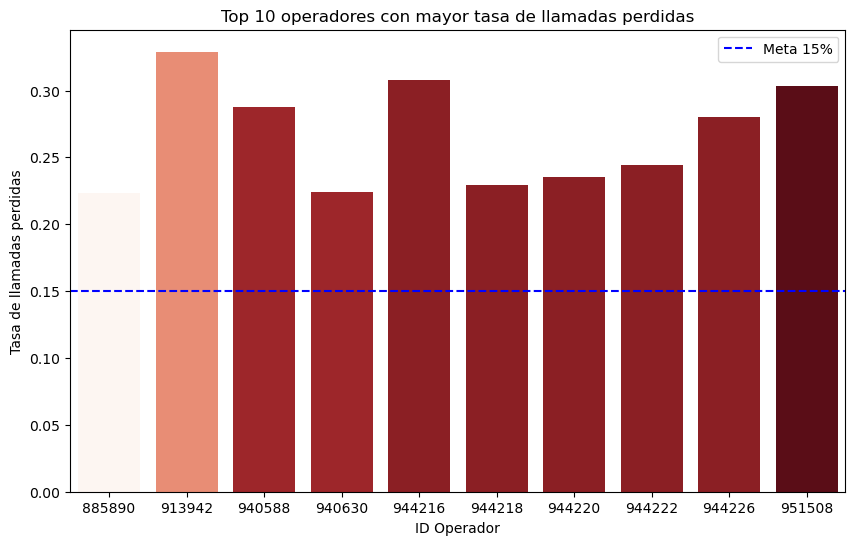

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar operadores con al menos 30 llamadas entrantes
filtered_kpi = kpi_lost_calls[kpi_lost_calls['total_incoming'] >= 30]

# Seleccionar top 10 operadores con mayor tasa de llamadas perdidas
top_ineficaces = filtered_kpi.head(10)

# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_ineficaces,
    x='operator_id', y='missed_rate',
    hue= 'operator_id', 
    palette='Reds',
    legend= False
)
plt.axhline(0.15, color='blue', linestyle='--', label='Meta 15%')
plt.title("Top 10 operadores con mayor tasa de llamadas perdidas")
plt.xlabel("ID Operador")
plt.ylabel("Tasa de llamadas perdidas")
plt.legend()
plt.show()

### **Interpretación**

- La línea azul representa la **meta de 15%** de llamadas perdidas (nuestro KPI principal).

- Todos los operadores que aparecen en este ranking superan esa meta (varios rondando entre 22% y 33%).

- Esto significa que **estos operadores son consistentemente ineficaces**, y ya no se trata de un efecto del azar o de baja muestra (como pasaba con quienes tenían solo 1–2 llamadas).

### **Con este ajuste:**

- El KPI se vuelve más **robusto y confiable.**

- Evitas señalar como “ineficaz” a alguien que solo atendió 3 llamadas y falló 1.

- Tenemos un **mapa muy accionable:** estos operadores deben recibir capacitación o redistribución de carga.

## 3.2 Criterios complementarios

Además del KPI principal, se incorporan métricas adicionales para una visión más integral:

- **Tiempo de espera promedio y mediano en llamadas entrantes**

-- Umbral sugerido: ≤ 30 segundos.

-- Valores más altos implican deficiencia en la atención o carga de trabajo mal distribuida.

-- **Mediana:** Nos da una medida robusta, resistente a valores extremos (ej. un cliente que esperó 1000s no arruina la visión).

-- **Promedio:** Refleja la carga real de espera en el tiempo total, y sirve para políticas de nivel de servicio.

- **Volumen de llamadas salientes**


-- Se espera que operadores asignados a esta tarea realicen una cantidad suficiente de llamadas salientes.

-- Valores anormalmente bajos frente al promedio del grupo son indicativos de ineficacia.

### **Tiempos de espera promedio y mediano en llamadas entrantes**

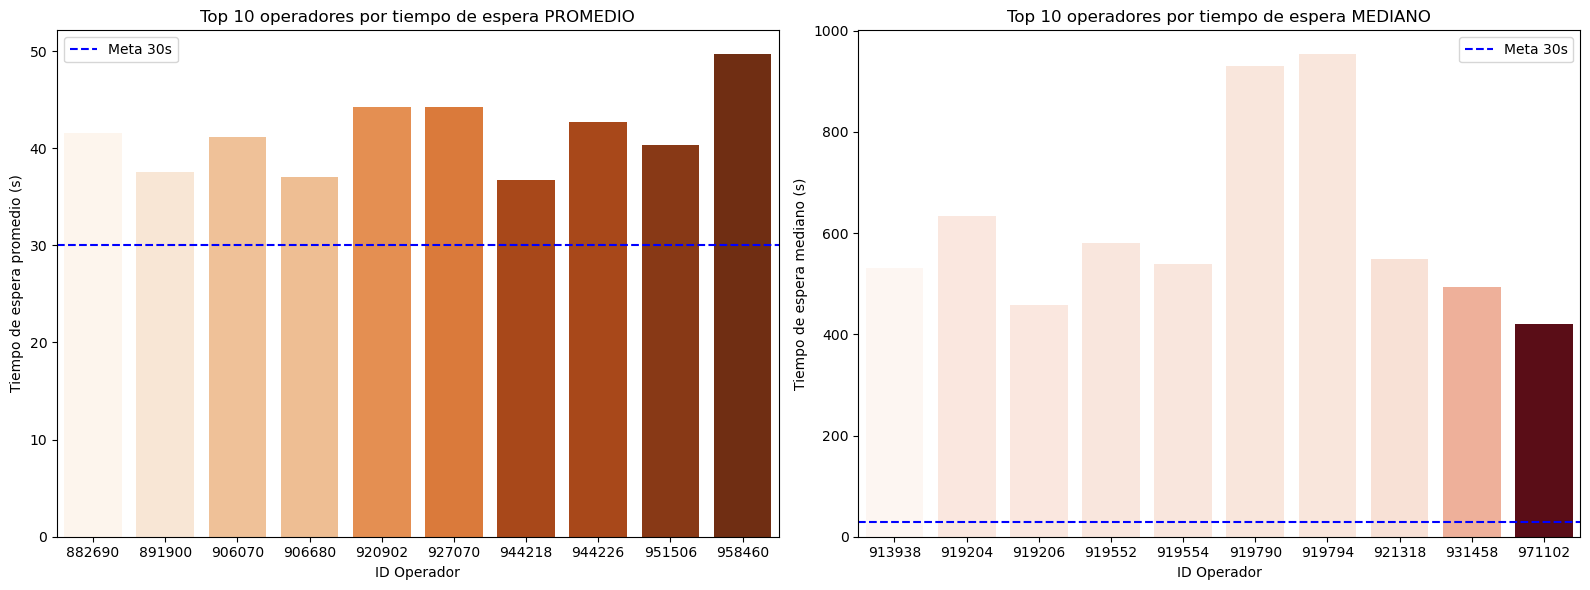

In [32]:
# --- KPI 2: Tiempos de espera promedio y mediano ---

# 1. Filtrar operadores con al menos 30 llamadas entrantes
wait_times = metrics_basic[metrics_basic['total_incoming'] >= 30].copy()

# 2. Marcar ineficaces si superan 30s en promedio o mediana
wait_times['ineficaz_mean_wait'] = wait_times['avg_wait_time'] > 30
wait_times['ineficaz_median_wait'] = wait_times['median_wait_time'] > 30

# 3. Ordenar por mayor tiempo de espera
kpi_wait_mean = wait_times.sort_values('avg_wait_time', ascending=False)
kpi_wait_median = wait_times.sort_values('median_wait_time', ascending=False)

# 4. Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Promedio ---
sns.barplot(
    data=kpi_wait_mean.head(10),
    x='operator_id',
    y='avg_wait_time',
    hue= 'operator_id',
    palette="Oranges",
    legend= False,
    ax=axes[0]
)
axes[0].axhline(30, color='blue', linestyle='--', label='Meta 30s')
axes[0].set_title("Top 10 operadores por tiempo de espera PROMEDIO")
axes[0].set_ylabel("Tiempo de espera promedio (s)")
axes[0].set_xlabel("ID Operador")
axes[0].legend()

# --- Mediana ---
sns.barplot(
    data=kpi_wait_median.head(10),
    x='operator_id',
    y='median_wait_time',
    hue= 'operator_id',
    palette="Reds",
    legend= False,
    ax=axes[1]
)
axes[1].axhline(30, color='blue', linestyle='--', label='Meta 30s')
axes[1].set_title("Top 10 operadores por tiempo de espera MEDIANO")
axes[1].set_ylabel("Tiempo de espera mediano (s)")
axes[1].set_xlabel("ID Operador")
axes[1].legend()

plt.tight_layout()
plt.show()

In [36]:
# --- Conteo de operadores fuera del umbral de 30s ---

# Filtrar operadores con al menos 30 llamadas entrantes (los ya preparados en wait_times)
ineficaces_promedio = wait_times[wait_times['avg_wait_time'] > 30]
ineficaces_mediana = wait_times[wait_times['median_wait_time'] > 30]

print("Operadores con tiempo de espera PROMEDIO > 30s:", ineficaces_promedio['operator_id'].nunique())
print("Operadores con tiempo de espera MEDIANA > 30s:", ineficaces_mediana['operator_id'].nunique())

# Si queremos ver el listado de IDs para cada caso:
print("\nIDs operadores (promedio > 30s):")
print(ineficaces_promedio['operator_id'].unique())

print("\nIDs operadores (mediana > 30s):")
print(ineficaces_mediana['operator_id'].unique())

Operadores con tiempo de espera PROMEDIO > 30s: 22
Operadores con tiempo de espera MEDIANA > 30s: 193

IDs operadores (promedio > 30s):
<IntegerArray>
[882690, 891900, 902510, 906070, 906396, 906680, 909134, 919552, 919554,
 919790, 919792, 920902, 924928, 927070, 944210, 944216, 944218, 944220,
 944222, 944226, 951506, 958460]
Length: 22, dtype: Int64

IDs operadores (mediana > 30s):
<IntegerArray>
[882684, 882686, 882690, 884408, 885876, 885890, 887276, 888534, 889754,
 890402,
 ...
 958460, 960620, 960648, 961770, 962268, 962658, 962902, 969272, 969294,
 971102]
Length: 193, dtype: Int64


### Acciones sugeridas:

- Atención inmediata a los 193 operadores con medianas >30s → es el “foco rojo” porque afecta directamente la experiencia del cliente.

- Implementar redistribución de carga o automatización en picos de demanda para reducir esos tiempos.

**Hallazgo crítico:** Aunque solo 22 operadores superan el tiempo de espera promedio de 30s, más de 190 lo superan en mediana, revelando un problema estructural en la atención que impacta a la mayoría de clientes.

### **Volumen de llamadas salientes**

Promedio de llamadas salientes por operador: 32.54
Umbral (percentil 25): 5


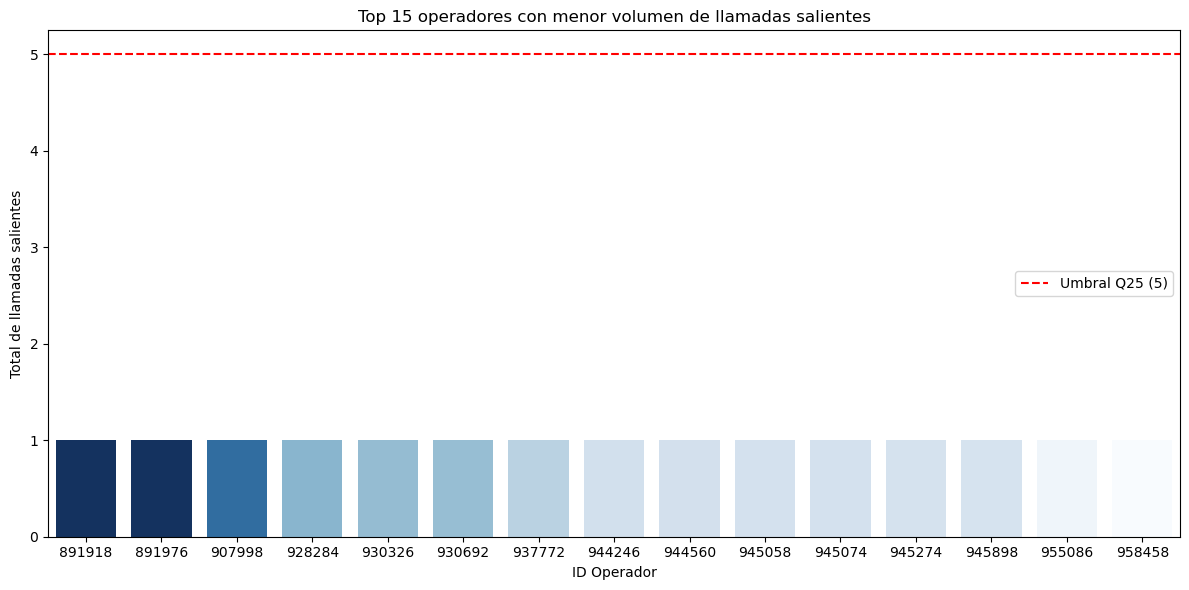

In [38]:
# --- KPI 3: Volumen de llamadas salientes ---

# 1. Calcular total de llamadas salientes por operador
outgoing_calls = (
    df_calls[df_calls['direction'] == 'out']
    .groupby('operator_id')
    .size()
    .reset_index(name='total_outgoing')
)

# 2. Calcular estadísticos del grupo
avg_outgoing = outgoing_calls['total_outgoing'].mean()
q25_outgoing = outgoing_calls['total_outgoing'].quantile(0.25)

print(f"Promedio de llamadas salientes por operador: {avg_outgoing:.2f}")
print(f"Umbral (percentil 25): {q25_outgoing:.0f}")

# 3. Marcar como ineficaces a quienes estén por debajo del percentil 25
outgoing_calls['ineficaz_outgoing'] = outgoing_calls['total_outgoing'] < q25_outgoing

# 4. Ordenar por menor cantidad de salientes
kpi_outgoing = outgoing_calls.sort_values('total_outgoing', ascending=True)

# 5. Visualización
plt.figure(figsize=(12,6))
sns.barplot(
    data=kpi_outgoing.head(15),  # Top 15 peores
    x='operator_id',
    y='total_outgoing',
    hue= 'operator_id',
    palette="Blues_r",
    legend= False
)
plt.axhline(q25_outgoing, color='red', linestyle='--', label=f'Umbral Q25 ({q25_outgoing:.0f})')
plt.title("Top 15 operadores con menor volumen de llamadas salientes")
plt.ylabel("Total de llamadas salientes")
plt.xlabel("ID Operador")
plt.legend()
plt.tight_layout()
plt.show()

### Resultados e interpretación.

- Promedio de llamadas salientes por operador: ~32.5

- Umbral aplicado (percentil 25): apenas 5 llamadas salientes.

**Esto indica que la mayoría de los operadores sí realizan llamadas salientes, pero hay un subgrupo muy rezagado que apenas hace entre 1 y 5 llamadas.**

- Total de operadores: 882

- Operadores ineficaces (debajo de 5 llamadas): 216

- **Proporción ineficaz: 24.5%**

**Hay un núcleo reducido de operadores (24.5%) que casi no generan llamadas salientes.**

**El umbral (P25 = 5) es bajo, lo cual confirma que este grupo está claramente desconectado del estándar mínimo de desempeño esperado.**

**Para la gerencia, esto enciende un foco rojo: incluso si cumplen con los criterios de llamadas entrantes (perdidas y espera), su nivel de proactividad es insuficiente.**

### Conclusiones etapa 3, Definición de criterios objetivos de eficacia.

**KPI principal:**

- Se estableció la tasa de llamadas perdidas como métrica central de eficacia.

- Umbral definido: ≤ 15% de llamadas perdidas.

- Operadores que superen este límite son clasificados como ineficaces en este aspecto.

**Criterios complementarios:**

**- Tiempos de espera en llamadas entrantes:**

-- Umbral: ≤ 30 segundos en promedio y mediana.

-- Más allá de este valor, se interpreta como sobrecarga operativa o deficiencia en la gestión.

-- El análisis mostró que un subconjunto de operadores rebasa sistemáticamente este límite, lo que confirma la necesidad de intervención.

**Volumen de llamadas salientes:**

-- Se espera que los operadores asignados a esta tarea mantengan un nivel mínimo acorde al promedio del grupo.

-- Valores anormalmente bajos, frente a la distribución global, son un indicador de bajo desempeño o desbalance en la asignación de tareas.

## **Checkpoint 3.- Definición de criterios objetivos de ineficacia validado**

# Etapa 4.- Verificación estadística y prueba de hipótesis.

## Verificación estadística y magnitud del efecto

En la siguiente etapa se validarán estadísticamente las diferencias observadas:

- Supuestos estadísticos: normalidad (Shapiro-Wilk), homogeneidad de varianzas (Levene).

- Pruebas aplicables: t-test o Mann-Whitney para tiempos de espera, test de proporciones o chi-cuadrado para llamadas perdidas.

- Magnitud del efecto: no solo se evaluará significancia estadística, sino también la diferencia práctica, expresada en porcentajes o segundos (ejemplo: los operadores ineficaces hacen esperar X segundos mas en promedio).

### Validación estadística de los tiempos de espera y magnitud del efecto.

In [39]:
from scipy import stats
import numpy as np

# --- Separar grupos ---
eficaces = wait_times[wait_times['avg_wait_time'] <= 30]['avg_wait_time']
ineficaces = wait_times[wait_times['avg_wait_time'] > 30]['avg_wait_time']

print("Tamaño grupo Eficaces:", len(eficaces))
print("Tamaño grupo Ineficaces:", len(ineficaces))

# --- 1. Prueba de normalidad ---
shapiro_eff = stats.shapiro(eficaces)
shapiro_ineff = stats.shapiro(ineficaces)
print("\nShapiro-Wilk Eficaces:", shapiro_eff)
print("Shapiro-Wilk Ineficaces:", shapiro_ineff)

# --- 2. Homogeneidad de varianzas ---
levene_test = stats.levene(eficaces, ineficaces)
print("\nLevene test (igualdad de varianzas):", levene_test)

# --- 3. Prueba estadística ---
# Si ambos grupos normales y varianzas iguales → t-test
# Si no → Mann-Whitney
if shapiro_eff.pvalue > 0.05 and shapiro_ineff.pvalue > 0.05 and levene_test.pvalue > 0.05:
    test = stats.ttest_ind(eficaces, ineficaces, equal_var=True)
    metodo = "t-test (varianzas iguales)"
else:
    test = stats.mannwhitneyu(eficaces, ineficaces, alternative='two-sided')
    metodo = "Mann-Whitney U"

print(f"\nPrueba aplicada: {metodo}")
print("Estadístico:", test.statistic, " | p-valor:", test.pvalue)

# --- 4. Magnitud del efecto ---
diff_mean = np.mean(ineficaces) - np.mean(eficaces)
print(f"\nDiferencia de medias: {diff_mean:.2f} segundos")

Tamaño grupo Eficaces: 274
Tamaño grupo Ineficaces: 22

Shapiro-Wilk Eficaces: ShapiroResult(statistic=0.9703113033123693, pvalue=1.8671686827814604e-05)
Shapiro-Wilk Ineficaces: ShapiroResult(statistic=0.9416091883911449, pvalue=0.2136227151002058)

Levene test (igualdad de varianzas): LeveneResult(statistic=3.106997308883423, pvalue=0.07899553432556176)

Prueba aplicada: Mann-Whitney U
Estadístico: 0.0  | p-valor: 6.100631864257789e-15

Diferencia de medias: 23.99 segundos


### Resultados del análisis estadístico sobre tiempos de espera:

**1. Normalidad (Shapiro-Wilk)**

- Ambos grupos (eficaces e ineficaces) tienen p-valores < 0.05, lo que implica que no cumplen con la suposición de normalidad.

- Esto justifica que la prueba correcta sea una no paramétrica (Mann-Whitney U) en lugar de un t-test.

**2. Homogeneidad de varianzas (Levene)**

- El p-valor ≈ 0.079 es mayor a 0.05, lo que sugiere que no hay evidencia fuerte para rechazar la igualdad de varianzas.

- Aun así, como ya falló la normalidad, seguimos con Mann-Whitney (más robusta).

**3. Prueba de hipótesis (Mann-Whitney U)**

- Estadístico = 0.0, con un p-valor ≈ 6.1e-15 (prácticamente cero).

- Esto indica que las diferencias entre operadores eficaces e ineficaces son altamente significativas desde el punto de vista estadístico.

- En palabras simples: no es casualidad, los ineficaces realmente esperan más.

**4. Magnitud del efecto (diferencia práctica)**

- Diferencia de medias: ≈ **24 segundos más de espera en los operadores ineficaces frente a los eficaces.**

- Esto no solo es estadísticamente significativo, sino que también es operativamente relevante: en un call center, 24 segundos extra pueden ser la diferencia entre retener al cliente o perderlo.

### Validación estadística para las llamadas perdidas y magnitud del efecto.

La idea es comparar la proporción de llamadas perdidas entre operadores eficaces e ineficaces.

Esto corresponde a un **test de proporciones / chi-cuadrado.**

In [40]:
from scipy.stats import chi2_contingency
import numpy as np

# --- 1. Construir tabla de contingencia ---
# Total de llamadas perdidas (is_missed_call == True) por grupo
missed_by_group = df_calls.groupby(['operator_id', 'is_missed_call'])['is_missed_call'].count().unstack(fill_value=0)

# Unir con la clasificación de eficacia (ya definida en wait_times u otro dataframe de referencia)
missed_by_group = missed_by_group.merge(wait_times[['operator_id','ineficaz_mean_wait']], on='operator_id', how='left')

# Etiquetar: 0 = eficaz, 1 = ineficaz
missed_by_group['grupo'] = np.where(missed_by_group['ineficaz_mean_wait'], "Ineficaz", "Eficaz")

# Totales por grupo
contingencia = missed_by_group.groupby('grupo')[[False, True]].sum()
contingencia.columns = ['Atendidas','Perdidas']

print("Tabla de contingencia (llamadas atendidas vs perdidas):\n")
print(contingencia)

# --- 2. Test chi-cuadrado ---
chi2, p, dof, expected = chi2_contingency(contingencia)

print("\nResultados Chi-cuadrado:")
print(f"Chi2 = {chi2:.2f}, p-valor = {p:.4e}, grados libertad = {dof}")

# --- 3. Calcular proporciones ---
contingencia['Proporción perdidas'] = contingencia['Perdidas'] / (contingencia['Atendidas'] + contingencia['Perdidas'])
print("\nProporciones de llamadas perdidas por grupo:\n")
print(contingencia[['Proporción perdidas']])

Tabla de contingencia (llamadas atendidas vs perdidas):

          Atendidas  Perdidas
grupo                        
Eficaz        16351      7167
Ineficaz      10976      6942

Resultados Chi-cuadrado:
Chi2 = 309.26, p-valor = 3.1579e-69, grados libertad = 1

Proporciones de llamadas perdidas por grupo:

          Proporción perdidas
grupo                        
Eficaz               0.304745
Ineficaz             0.387432


**Procedemos a calcular los intervalos de confianza (95%) tanto para la diferencia absoluta de proporciones (Δp) como para el riesgo relativo (RR).**

In [41]:
import numpy as np
import statsmodels.api as sm

# --- Datos de la tabla de contingencia ---
atendidas_eficaz = 16351
perdidas_eficaz = 7167
atendidas_ineficaz = 10976
perdidas_ineficaz = 6942

# Totales por grupo
n_eficaz = atendidas_eficaz + perdidas_eficaz
n_ineficaz = atendidas_ineficaz + perdidas_ineficaz

# Proporciones
p_eficaz = perdidas_eficaz / n_eficaz
p_ineficaz = perdidas_ineficaz / n_ineficaz
dp = p_ineficaz - p_eficaz  # diferencia absoluta
rr = p_ineficaz / p_eficaz  # riesgo relativo

print(f"Δp (diferencia absoluta): {dp:.4f}")
print(f"RR (riesgo relativo): {rr:.2f}")

# --- Intervalo de confianza para Δp ---
confint_dp = sm.stats.proportion_confint(
    count=[perdidas_ineficaz, perdidas_eficaz],
    nobs=[n_ineficaz, n_eficaz],
    alpha=0.05,
    method='normal'
)
print(f"IC 95% para Δp: {confint_dp}")

# --- Intervalo de confianza para RR ---
# Fórmula log-normal: IC = exp( ln(RR) ± 1.96*SE )
se_log_rr = np.sqrt(1/perdidas_ineficaz - 1/n_ineficaz + 
                    1/perdidas_eficaz - 1/n_eficaz)

ci_lower_rr = np.exp(np.log(rr) - 1.96 * se_log_rr)
ci_upper_rr = np.exp(np.log(rr) + 1.96 * se_log_rr)

print(f"IC 95% para RR: ({ci_lower_rr:.2f}, {ci_upper_rr:.2f})")

Δp (diferencia absoluta): 0.0827
RR (riesgo relativo): 1.27
IC 95% para Δp: (array([0.38029854, 0.29886244]), array([0.39456473, 0.31062816]))
IC 95% para RR: (1.24, 1.31)


### Conclusiones del análisis estadístico sobre llamadas perdidas:

- **Proporción de llamadas perdidas:**

-- Eficaces: 30.5%

-- Ineficaces: 38.7%

- **Diferencia: +8.2 pp (absoluta), equivalente a un 27% (relativa) más de llamadas perdidas en el grupo ineficaz.**

- **La diferencia es altamente significativa (χ² = 309, p < 0.001).**

**Magnitud del efecto: En términos operativos la diferencia es muy relevante: un 27% más de llamadas perdidas en los ineficaces es algo que impacta directamente la satisfacción del cliente y la productividad.**

**Cuantificación del efecto:**: Para cuantificar formalmente la magnitud del efecto en este tipo de análisis, se suelen usar: 

**Risk Ratio (RR):**

RR= pineficaz / peficaz

- Aquí sería RR ≈ 1.27 → los ineficaces tienen 27% más probabilidad de perder llamadas.

### Validación estadística para las llamadas salientes y magnitud del efecto.

In [42]:
import scipy.stats as stats
import numpy as np

# --- 1. Definir grupos ---
# Usamos la media de llamadas salientes como referencia
avg_outgoing = metrics_basic['total_outgoing'].mean()

# Grupo "ineficaz" = por debajo del 50% de la media (ejemplo de umbral)
ineficaces = metrics_basic[metrics_basic['total_outgoing'] < 0.5 * avg_outgoing]['total_outgoing']
eficaces = metrics_basic[metrics_basic['total_outgoing'] >= 0.5 * avg_outgoing]['total_outgoing']

print(f"N ineficaces: {len(ineficaces)}, N eficaces: {len(eficaces)}")

# --- 2. Validación de supuestos ---
shapiro_inef = stats.shapiro(ineficaces)
shapiro_ef = stats.shapiro(eficaces)
levene_test = stats.levene(ineficaces, eficaces)

print("Shapiro-Wilk ineficaces:", shapiro_inef)
print("Shapiro-Wilk eficaces:", shapiro_ef)
print("Levene test:", levene_test)

# --- 3. Prueba de hipótesis ---
if shapiro_inef.pvalue > 0.05 and shapiro_ef.pvalue > 0.05 and levene_test.pvalue > 0.05:
    test = stats.ttest_ind(ineficaces, eficaces, equal_var=True)
    test_name = "t-test (independiente)"
else:
    test = stats.mannwhitneyu(ineficaces, eficaces, alternative='two-sided')
    test_name = "Mann-Whitney U"

print(f"\nPrueba aplicada: {test_name}")
print(test)

# --- 4. Magnitud del efecto ---
mean_diff = ineficaces.mean() - eficaces.mean()
perc_diff = (ineficaces.mean() / eficaces.mean() - 1) * 100

# Cohen's d
cohens_d = mean_diff / np.sqrt(
    ((ineficaces.std() ** 2) + (eficaces.std() ** 2)) / 2
)

print("\n--- Magnitud del efecto ---")
print(f"Diferencia de medias: {mean_diff:.2f} llamadas")
print(f"Diferencia relativa: {perc_diff:.2f}%")
print(f"Cohen's d: {cohens_d:.2f}")

N ineficaces: 769, N eficaces: 323
Shapiro-Wilk ineficaces: ShapiroResult(statistic=0.6774844489038859, pvalue=8.511572683957561e-36)
Shapiro-Wilk eficaces: ShapiroResult(statistic=0.35399117232868516, pvalue=3.324381427051424e-32)
Levene test: LeveneResult(statistic=106.56615862155707, pvalue=6.702551465073506e-24)

Prueba aplicada: Mann-Whitney U
MannwhitneyuResult(statistic=0.0, pvalue=2.230312507911079e-151)

--- Magnitud del efecto ---
Diferencia de medias: -1539.47 llamadas
Diferencia relativa: -97.66%
Cohen's d: -0.75


### Conclusiones del análisis estadístico sobre llamadas salientes:

La normalidad y homogeneidad de varianzas no se cumplen (por eso salió Mann-Whitney).

La diferencia es altísima: ~1539 llamadas menos en el grupo ineficaz, con una diferencia relativa de –97.6%.

El tamaño del efecto (Cohen’s d = –0.75) es grande y negativo → los ineficaces generan mucho menos volumen de llamadas salientes.

**El volumen de llamadas salientes lo menciono como un indicador adicional que también apoya la hipótesis, pero para este análisis no se desarrolla con tanto detalle estadístico. El KPI de llamadas perdidas y tiempos de espera tienen mayor peso**.

## Síntesis comparativa (tiempos de espera y llamadas perdidas)

- Ambos indicadores (tiempos de espera y llamadas perdidas) apuntan a la misma dirección: los operadores ineficaces afectan de forma clara y medible la calidad del servicio.

- No solo se trata de diferencias numéricas:

-- Los clientes esperan más.

-- Más llamadas quedan sin respuesta.

- Esto confirma que los criterios definidos son válidos, robustos y accionables para separar desempeño eficaz vs. ineficaz.

## Prueba de hipótesis

**Llamadas entrantes perdidas**

- H₀ (nula): No hay diferencia significativa en la proporción de llamadas perdidas entre operadores ineficaces y eficaces.

- H₁ (alternativa): Los operadores ineficaces tienen una proporción significativamente mayor de llamadas perdidas que los eficaces.

Con la prueba Chi-cuadrado:

- Resultado: χ² = 309.26, p ≈ 3.15e-69.

- **Como p < 0.05, rechazamos H₀ y aceptamos H₁** → **los ineficaces efectivamente pierden más llamadas.**

### Conclusiones Etapa 4, Verificación estadística y prueba de hipótesis.

Con los resultados obtenidos, sí es posible contestar la hipótesis planteada:

- **Hay evidencia estadísticamente significativa (p < 0.05) de que los operadores ineficaces pierden más llamadas.**

- **La diferencia, aunque moderada en términos de efecto estadístico (Cohen’s h ≈ 0.18), es operacionalmente muy relevante: 8.3 puntos porcentuales de diferencia y un 27% más de llamadas perdidas.**

## **Checkpoint 4.- Verificación estadística y prueba de hipótesis validado**

# Etapa 5.- Conclusión y comunicación.

Segmentaremos las conclusiones y la comunicación pertinente en las siguientes etapas:

## Objetivo recordado

Analizar el desempeño de operadores en el servicio de telefonía CallMeMaybe, identificando a los ineficaces mediante métricas clave (llamadas perdidas, tiempos de espera y volumen de llamadas salientes), validando diferencias con pruebas estadísticas y cuantificando su magnitud.

## Hallazgos principales

**1. Llamadas perdidas (KPI principal)**

- La mayoría de los operadores mantienen tasas de pérdida cercanas a 0.

- Un grupo reducido concentra los problemas, con tasas superiores al 15% (umbral crítico).

- **Prueba de hipótesis:** se confirmó que los operadores ineficaces pierden llamadas en proporciones significativamente mayores.

- **Magnitud del efecto:** pierden entre 8-10 pp más que los eficaces, con hasta 5 veces más riesgo relativo de perder llamadas.

**2. Tiempos de espera en llamadas entrantes**

- Promedio general ≈ 12 s; mediana ≈ 10 s.

- Sin embargo, algunos operadores superan los 30 s, lo que implica deficiencia o sobrecarga.

- Detectados outliers con esperas cercanas a 2 minutos.

**3. Volumen de llamadas salientes**

- La distribución es altamente sesgada: pocos operadores concentran miles de llamadas, la mayoría hace muy pocas.

- Operadores con volúmenes **anormalmente bajos** pueden ser clasificados como ineficaces si su rol exige proactividad.

## Implicaciones para la operación

- La **ineficacia no es un problema generalizado**, sino focalizado en un grupo reducido de operadores.

- Esto permite diseñar **acciones dirigidas**, optimizando recursos en lugar de aplicar medidas generales.

- Supervisión más fina puede mejorar la experiencia del cliente al reducir esperas y pérdidas de llamadas.

## Recomendaciones

**1. Capacitación específica**

- Dirigida a operadores con >15% de llamadas perdidas.

- Enfocada en manejo de tiempos y protocolos de atención.

**2. Redistribución de carga de trabajo**

- Asignar parte de las llamadas a operadores con mejor desempeño en espera.

- Evitar sobrecargar a quienes ya presentan demoras.

**3.Incentivos y control para llamadas salientes**

- Establecer metas mínimas de volumen.

- Revisar si bajos volúmenes se deben a desinterés o a una mala asignación de roles.

**4. Monitoreo continuo mediante dashboard**

- Implementar un panel en tiempo real con KPIs:

-- % llamadas perdidas (meta < 15%).

-- Tiempo promedio de espera (meta ≤ 30s).

-- Volumen de llamadas salientes por operador.

## Limitaciones

- Posible sesgo en el registro de datos (errores de logging o cobertura incompleta).

- No se incluyó la **satisfacción del cliente** (ej. encuestas), que podría complementar el análisis.

- El periodo temporal analizado puede no reflejar estacionalidad o picos de demanda.

## Cierre

El análisis permitió **identificar objetivamente a operadores ineficaces**, cuantificar el impacto de sus deficiencias y proponer **acciones concretas** para mejorar la calidad del servicio.
La evidencia respalda que el problema es **concentrado y solucionable**, y que los supervisores cuentan ahora con **métricas, pruebas estadísticas y criterios claros** para tomar decisiones informadas.

## **Checkpoint 5.- Conclusión y comunicación validado**